In [2]:
data_root = "../../data/"

#stats stuff
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# ML stuff
import numpy as np
from numpy.fft import *
import torch
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import pandas as pd
import lightgbm as lgb


# DL stuff
from torch.autograd import Variable
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
from torch.utils.data import Dataset


# plotting
import matplotlib.pyplot as plt
import seaborn as sns



# basic stuff
import datetime
import requests
import io
import os
from collections import Counter
from tqdm import tqdm

# relative imports
# from GBT_preprocess import get_Xy,\
#      get_train_test, reindex, get_stock,\
#          sliding_windows_mutli_features,\
#              get_features, get_train_df
# from hfuncs import check_mkdir

In [3]:
# set index as datetime
def date_index_nasdaq(nasdaq):
    nasdaq_c = nasdaq.copy()
    dates = pd.to_datetime(nasdaq_c.Date)
    nasdaq_c.set_index(dates, inplace=True)
    # set date as index
    nasdaq_c.drop("Date", axis=1, inplace=True)
    nasdaq_c = nasdaq_c["2012-05-18":]
    return nasdaq_c

############## REINDEX FUNCTION AND PREPARE_STOCK FUNCTION ARE PRETTY MUCH SAME, HOWEVER, I PREFER THE PRIOR ##################
# for ARIMA or some shit    
def reindex(df):
    return df.reindex(pd.date_range(df.index[0], df.index[-1])).fillna(method="ffill")

# for prepare_stock
def date_range_df(start, end, column_name = "Time"):
    date_range = pd.date_range(start, end)
    df = pd.DataFrame(date_range, columns = [column_name])
    df.set_index(column_name, inplace=True)
    return df

# merging with date range df
def prepare_stock(nasdaq, start, end, stock_name="AAPL", drop=True):
    nasdaq = nasdaq.loc[nasdaq["Name"]==stock_name]
    dates = date_range_df(start, end)
    new_nasdaq = dates.merge(nasdaq, how="left", left_index=True, right_index=True)
    if drop:
        new_nasdaq.dropna(inplace=True)
    return new_nasdaq
#############################################################################################################################

# create features volatility, volume, adj close
def get_features(nasdaq, features):
    #rename Adj Close
    
    nasdaq.rename(columns={"Adj Close":"Adj_Close"}, inplace=True) 
    nasdaq["log_Volatility"] = np.log(nasdaq.High - nasdaq.Low + 1)
    nasdaq["log_Volume"] = np.log(nasdaq.Volume + 1) 
    nasdaq["log_Adj_Close"] = np.log(nasdaq["Adj_Close"] + 1)
    if 'Adj_Close' not in features:
        nasdaq.drop(columns=["Adj_Close"], inplace=True)
    # nasdaq["log_Adj_Close_diff"] = nasdaq["log_Adj_Close"].diff()

    nasdaq.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
    # nasdaq = nasdaq[features]

    # nasdaq.dropna(inplace = True)
    return nasdaq

# this will return feature engineered stock dataframe
def get_stock(nasdaq, features, stock_name="AAPL"):
    nasdaq_c = date_index_nasdaq(nasdaq)
    stock = prepare_stock(nasdaq_c, nasdaq_c.index[0], nasdaq_c.index[-1], stock_name)
    stock = get_features(stock, features)
    stock.fillna("ffill", inplace=True)
    return stock

# plot heatmap for top stocks
def plot_attribute(nasdaq, using,feature="log_Adj_Close"):
    stocks = pd.DataFrame()
    for name in using:
        stocks[name] = get_stock(nasdaq, name)[feature]
    stocks.dropna(inplace=True)
    stocks.plot()
    plt.show()

####### In the 2 functions below, we are adding weekday however ###########
####### prob we could have done this in like get_stock or something #######
# the main difference between the two is , the prior is just adding weekday at the end,
# whereas the latter function is adding it to every stock
def get_train_df(nasdaq, using, features):
    df_features_arr = reindex(get_stock(nasdaq, using[0])).to_numpy().T
    for name in using[1:]:
        adding = reindex(get_stock(nasdaq, name)).to_numpy().T
        df_features_arr = np.concatenate([df_features_arr, adding])
    df_features_arr = df_features_arr.T

    ## df_features = pd.DataFrame(data=df_features_arr, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))
    
    # making columns
    # features must not include weekday here
    if "weekday" in features:
        features.remove("weekday")
    col_one = []
    for element in using:
        for i in range(len(features)):
            col_one.append(element)
    col_two = list(features)*len(using)
    # print(len(col_one), len(col_two))

    # scaling 
    scaler = MinMaxScaler((-1, 1))
    scaled = scaler.fit_transform(df_features_arr)
    df_features = pd.DataFrame(data=scaled, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))

    df_features.index = pd.date_range("2012-05-18", "2021-09-10")

    day_of_week = np.array(list(map(lambda date: date.weekday(), df_features.index)))
    day_of_week = day_of_week.reshape(-1, 1)
    day_of_week = pd.Series(data=scaler.fit_transform(day_of_week).reshape(-1,), index = df_features.index)
    df_features["weekday"] = day_of_week
    if "weekday" not in features:
        features.append("weekday")

    return df_features, features

# for feeding into network
def get_train_arr(nasdaq, using, features):
    df_features_arr = []
    for name in using:
        arr = reindex(get_stock(nasdaq, name)).to_numpy()
        # scaling for each column, for each stock_df in nasdaq
        scaler = MinMaxScaler(feature_range=(-1, 1))
        arr_scaled = scaler.fit_transform(arr)    

        # adding day of week
        day_of_week = np.array(list(map(lambda date: date.weekday(), pd.date_range("2012-05-18", "2021-09-10"))))
        day_of_week = day_of_week.reshape(-1, 1)
        day_of_week = scaler.fit_transform(day_of_week)
      
        arr_scaled = np.concatenate([arr_scaled, day_of_week], axis=1)

        df_features_arr.append(arr_scaled)


    df_features_arr = np.array(df_features_arr)
    if "weekday" not in features:
        features.append("weekday")
    df_features_arr = df_features_arr.reshape(-1, len(features), 7)

    return df_features_arr, features

def sliding_windows_mutli_features(data, seq_length, target_cols_ids):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        #change here after finishing feature engineering process
        _x = data[i:(i+seq_length), :] 
        _y = data[i+seq_length, target_cols_ids] ## column 1 contains the labbel(log_Adj_Close)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

def get_Xy(df, window_size):
    log_adj_close_cols_ids = []
    volatility_cols_ids = []
    volume_cols_ids = []
    weekday_col_id = []
    count = 0
    for col in df.columns:
        # print(col)
        if col[1] == "Adj_Close":
            df.drop(col, axis=1, inplace=True)
            count -= 1
        if col[1] == "log_Adj_Close":
            log_adj_close_cols_ids.append(count)
        if col[1] == "log_Volume":
            volume_cols_ids.append(count)
        if col[1] == "log_Volatility":
            volatility_cols_ids.append(count)
        if col[0] == "weekday":
            weekday_col_id.append(count)
        count += 1
    df = df.to_numpy()
    x, y = sliding_windows_mutli_features(df, window_size, log_adj_close_cols_ids)

    # x.shape, y.shape
    return x, y

def get_train_test(x, y, train_ratio):
    train_size = int(len(y)*train_ratio)
    test_size = len(y) - train_size

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    return trainX, trainY, testX, testY

In [4]:
nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")

train_ratio = 0.80
features = ["log_Volatility", "log_Volume", "log_Adj_Close"]
using = ['FB', 'TSLA', 'AAPL', 'AMZN', 'NVDA', 'MSFT', 'GOOGL']
df = get_train_df(nasdaq, using, features)

In [5]:
from optuna.integration import lightgbm as lgb
import optuna

aapl = get_stock(nasdaq, features)
train_size = int(len(aapl)*train_ratio)
y_ = aapl[["log_Adj_Close"]]
y = y_.shift(-1) - y_ 
y = y.iloc[:-1]
X = aapl.iloc[:-1]
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)

In [15]:
def load_for_lgb():
    nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")
    train_ratio = 0.90
    valid_ratio = 0.15
    features = ["log_Volatility", "log_Volume", "log_Adj_Close"]
    # using = ['FB', 'TSLA', 'AAPL', 'AMZN', 'NVDA', 'MSFT', 'GOOGL']

    aapl = get_stock(nasdaq, features)
    train_size = int(len(aapl)*train_ratio)
    y_ = aapl[["log_Adj_Close"]]
    y = y_.shift(-1) - y_ 
    y = y.iloc[:-1]
    X = aapl.iloc[:-1]
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    valid_size = int(len(aapl)*valid_ratio)
    X_train_v, X_valid = X[:-valid_size], X[-valid_size:]
    y_train_v, y_valid = y[:-valid_size], y[-valid_size:]

    return X_train, y_train, X_test, y_test, X_train_v, y_train_v, X_valid, y_valid

In [16]:
import warnings
warnings.filterwarnings("ignore")

def objective(trial):
    X_train, y_train, X_test, y_test, X_train_v, y_train_v, X_valid, y_valid = load_for_lgb()

    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    lgb_train = lgb.Dataset(X_train_v, label=y_train_v)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid)
    model = lgb.train(param, lgb_train, valid_sets=lgb_valid)

    y_pred = model.predict(X_test)

    error = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))

    return error

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)#42 secs for 1 trial

print("finished_trials", len(study.trials))
print("best trial", study.best_trial.params)

best_params = study.best_trial.params

[I 2022-01-14 12:34:54,742] A new study created in memory with name: no-name-6a8a943c-8fb5-48a3-8a60-012bf76fe18a
[I 2022-01-14 12:34:54,932] A new study created in memory with name: no-name-d0cd9e28-6f6d-4671-81c4-b7c8c344b0dd
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 0.0199084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 0.0199309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	val

feature_fraction, val_score: 0.026834:  14%|#4        | 1/7 [00:02<00:16,  2.73s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's rmse: 0.0269892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's rmse: 0.0270388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	valid_0's rmse: 0.0271344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	valid_0's rmse: 0.0271458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's rmse: 0.0270486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's rmse: 0.0271747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's rmse: 0.0271074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's rmse: 0.0270153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's rmse: 0.026932
[LightGBM] [Warning] No further splits

feature_fraction, val_score: 0.026834:  29%|##8       | 2/7 [00:05<00:14,  2.91s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's rmse: 0.0269892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's rmse: 0.0270388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	valid_0's rmse: 0.0271344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	valid_0's rmse: 0.0271458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's rmse: 0.0270486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's rmse: 0.0271747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's rmse: 0.0271074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's rmse: 0.0270153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's rmse: 0.026932
[LightGBM] [Warning] No further splits

feature_fraction, val_score: 0.026834:  43%|####2     | 3/7 [00:08<00:11,  2.85s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[998]	valid_0's rmse: 0.0287827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	valid_0's rmse: 0.0289371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's rmse: 0.0287249
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start

feature_fraction, val_score: 0.026834:  57%|#####7    | 4/7 [00:11<00:08,  2.94s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's rmse: 0.0269892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's rmse: 0.0270388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	valid_0's rmse: 0.0271344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	valid_0's rmse: 0.0271458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's rmse: 0.0270486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's rmse: 0.0271747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's rmse: 0.0271074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's rmse: 0.0270153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's rmse: 0.026932
[LightGBM] [Warning] No further splits

feature_fraction, val_score: 0.026834:  71%|#######1  | 5/7 [00:14<00:05,  2.96s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's rmse: 0.026932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	valid_0's rmse: 0.0270368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's rmse: 0.0271014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's rmse: 0.0272444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[994]	valid_0's rmse: 0.0271739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	valid_0's rmse: 0.0270937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	valid_0's rmse: 0.0269579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[997]	valid_0's rmse: 0.0270174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[998]	valid_0's rmse: 0.0270395
[LightGBM] [Warning] No further splits

feature_fraction, val_score: 0.026834:  86%|########5 | 6/7 [00:17<00:02,  2.90s/it]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 0.0199824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 0.0199642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	val

feature_fraction, val_score: 0.025421: 100%|##########| 7/7 [00:20<00:00,  2.93s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[998]	valid_0's rmse: 0.0254147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	valid_0's rmse: 0.0254168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's rmse: 0.0254205


num_leaves, val_score: 0.025421:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 0.0199824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 0.0199642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	val

num_leaves, val_score: 0.025421:   5%|5         | 1/20 [00:02<00:54,  2.88s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	valid_0's rmse: 0.0254168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's rmse: 0.0254205
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1

num_leaves, val_score: 0.025421:  10%|#         | 2/20 [00:05<00:54,  3.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	valid_0's rmse: 0.0255496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	valid_0's rmse: 0.0255782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	valid_0's rmse: 0.0255639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's rmse: 0.0252902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's rmse: 0.0252721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	valid_0's rmse: 0.0254006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	valid_0's rmse: 0.0254088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's rmse: 0.0252885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's rmse: 0.0252834
[LightGBM] [Warning] No further split

num_leaves, val_score: 0.025421:  15%|#5        | 3/20 [00:08<00:50,  2.97s/it]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 0.0199824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 0.0199642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	val

num_leaves, val_score: 0.025421:  20%|##        | 4/20 [00:11<00:44,  2.78s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	valid_0's rmse: 0.0254088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's rmse: 0.0252885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's rmse: 0.0252834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's rmse: 0.0253856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's rmse: 0.0251975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's rmse: 0.0252487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	valid_0's rmse: 0.0251518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's rmse: 0.0252887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's rmse: 0.0254907
[LightGBM] [Warning] No further split

num_leaves, val_score: 0.025421:  25%|##5       | 5/20 [00:14<00:41,  2.74s/it]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 0.0199824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 0.0199642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	val

num_leaves, val_score: 0.025421:  30%|###       | 6/20 [00:16<00:38,  2.77s/it]

[973]	valid_0's rmse: 0.0254295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	valid_0's rmse: 0.0254086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's rmse: 0.025423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	valid_0's rmse: 0.0255834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[977]	valid_0's rmse: 0.0256454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	valid_0's rmse: 0.025737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	valid_0's rmse: 0.0255496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	valid_0's rmse: 0.0255782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	valid_0's rmse: 0.0255639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's rmse: 0.0252902
[LightG

num_leaves, val_score: 0.025421:  35%|###5      | 7/20 [00:19<00:35,  2.72s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	valid_0's rmse: 0.0254493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[969]	valid_0's rmse: 0.025627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[970]	valid_0's rmse: 0.0256186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[971]	valid_0's rmse: 0.0254856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[972]	valid_0's rmse: 0.0253288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[973]	valid_0's rmse: 0.0254295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	valid_0's rmse: 0.0254086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's rmse: 0.025423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	valid_0's rmse: 0.0255834
[LightGBM] [Warning] No further splits 

num_leaves, val_score: 0.025421:  40%|####      | 8/20 [00:22<00:32,  2.73s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	valid_0's rmse: 0.0254387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	valid_0's rmse: 0.0252845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[997]	valid_0's rmse: 0.0254045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[998]	valid_0's rmse: 0.0254147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	valid_0's rmse: 0.0254168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's rmse: 0.0254205
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You ca

num_leaves, val_score: 0.025421:  45%|####5     | 9/20 [00:25<00:30,  2.73s/it]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 0.0199824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 0.0199642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	val

num_leaves, val_score: 0.025421:  50%|#####     | 10/20 [00:27<00:28,  2.81s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[970]	valid_0's rmse: 0.0256186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[971]	valid_0's rmse: 0.0254856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[972]	valid_0's rmse: 0.0253288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[973]	valid_0's rmse: 0.0254295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	valid_0's rmse: 0.0254086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's rmse: 0.025423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	valid_0's rmse: 0.0255834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[977]	valid_0's rmse: 0.0256454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	valid_0's rmse: 0.025737
[LightGBM] [Warning] No further splits 

num_leaves, val_score: 0.023529:  55%|#####5    | 11/20 [00:28<00:19,  2.19s/it]

[899]	valid_0's rmse: 0.0231883
[900]	valid_0's rmse: 0.023349
[901]	valid_0's rmse: 0.0234287
[902]	valid_0's rmse: 0.0231912
[903]	valid_0's rmse: 0.0231405
[904]	valid_0's rmse: 0.0230769
[905]	valid_0's rmse: 0.0230556
[906]	valid_0's rmse: 0.0230546
[907]	valid_0's rmse: 0.0231147
[908]	valid_0's rmse: 0.0231098
[909]	valid_0's rmse: 0.0229833
[910]	valid_0's rmse: 0.0229928
[911]	valid_0's rmse: 0.0230023
[912]	valid_0's rmse: 0.0231522
[913]	valid_0's rmse: 0.0231712
[914]	valid_0's rmse: 0.0231618
[915]	valid_0's rmse: 0.023212
[916]	valid_0's rmse: 0.0233452
[917]	valid_0's rmse: 0.0235765
[918]	valid_0's rmse: 0.0235726
[919]	valid_0's rmse: 0.0236193
[920]	valid_0's rmse: 0.0237968
[921]	valid_0's rmse: 0.0236531
[922]	valid_0's rmse: 0.0236494
[923]	valid_0's rmse: 0.0235256
[924]	valid_0's rmse: 0.0235087
[925]	valid_0's rmse: 0.0236036
[926]	valid_0's rmse: 0.0235964
[927]	valid_0's rmse: 0.0235535
[928]	valid_0's rmse: 0.023548
[929]	valid_0's rmse: 0.0235622
[930]	valid

num_leaves, val_score: 0.023529:  60%|######    | 12/20 [00:29<00:15,  1.89s/it]

[926]	valid_0's rmse: 0.0240112
[927]	valid_0's rmse: 0.0239593
[928]	valid_0's rmse: 0.0239468
[929]	valid_0's rmse: 0.0239618
[930]	valid_0's rmse: 0.0239473
[931]	valid_0's rmse: 0.0238568
[932]	valid_0's rmse: 0.0239953
[933]	valid_0's rmse: 0.0241367
[934]	valid_0's rmse: 0.0242072
[935]	valid_0's rmse: 0.0243044
[936]	valid_0's rmse: 0.0243999
[937]	valid_0's rmse: 0.0243292
[938]	valid_0's rmse: 0.0243276
[939]	valid_0's rmse: 0.0243138
[940]	valid_0's rmse: 0.0243362
[941]	valid_0's rmse: 0.0243854
[942]	valid_0's rmse: 0.0243782
[943]	valid_0's rmse: 0.0243876
[944]	valid_0's rmse: 0.0243862
[945]	valid_0's rmse: 0.0243718
[946]	valid_0's rmse: 0.0242123
[947]	valid_0's rmse: 0.0242262
[948]	valid_0's rmse: 0.0242254
[949]	valid_0's rmse: 0.0242296
[950]	valid_0's rmse: 0.0242262
[951]	valid_0's rmse: 0.0242301
[952]	valid_0's rmse: 0.0244238
[953]	valid_0's rmse: 0.0244133
[954]	valid_0's rmse: 0.0243859
[955]	valid_0's rmse: 0.0243976
[956]	valid_0's rmse: 0.0243788
[957]	va

num_leaves, val_score: 0.023529:  65%|######5   | 13/20 [00:30<00:10,  1.55s/it]

[924]	valid_0's rmse: 0.0235087
[925]	valid_0's rmse: 0.0236036
[926]	valid_0's rmse: 0.0235964
[927]	valid_0's rmse: 0.0235535
[928]	valid_0's rmse: 0.023548
[929]	valid_0's rmse: 0.0235622
[930]	valid_0's rmse: 0.0235475
[931]	valid_0's rmse: 0.023443
[932]	valid_0's rmse: 0.0234104
[933]	valid_0's rmse: 0.023498
[934]	valid_0's rmse: 0.0235749
[935]	valid_0's rmse: 0.0236662
[936]	valid_0's rmse: 0.0237813
[937]	valid_0's rmse: 0.0237296
[938]	valid_0's rmse: 0.0237281
[939]	valid_0's rmse: 0.0237223
[940]	valid_0's rmse: 0.0237374
[941]	valid_0's rmse: 0.0237275
[942]	valid_0's rmse: 0.0237136
[943]	valid_0's rmse: 0.0237172
[944]	valid_0's rmse: 0.0237156
[945]	valid_0's rmse: 0.023706
[946]	valid_0's rmse: 0.0235436
[947]	valid_0's rmse: 0.0235585
[948]	valid_0's rmse: 0.0235628
[949]	valid_0's rmse: 0.0235585
[950]	valid_0's rmse: 0.0235509
[951]	valid_0's rmse: 0.0235543
[952]	valid_0's rmse: 0.0237492
[953]	valid_0's rmse: 0.0237407
[954]	valid_0's rmse: 0.023726
[955]	valid_0

num_leaves, val_score: 0.022663:  70%|#######   | 14/20 [00:31<00:07,  1.24s/it]

[968]	valid_0's rmse: 0.0230261
[969]	valid_0's rmse: 0.0232507
[970]	valid_0's rmse: 0.0232472
[971]	valid_0's rmse: 0.0230449
[972]	valid_0's rmse: 0.0229359
[973]	valid_0's rmse: 0.023057
[974]	valid_0's rmse: 0.0230414
[975]	valid_0's rmse: 0.0230506
[976]	valid_0's rmse: 0.0232277
[977]	valid_0's rmse: 0.0233156
[978]	valid_0's rmse: 0.0234228
[979]	valid_0's rmse: 0.0231402
[980]	valid_0's rmse: 0.0231885
[981]	valid_0's rmse: 0.0231869
[982]	valid_0's rmse: 0.0229036
[983]	valid_0's rmse: 0.0228879
[984]	valid_0's rmse: 0.0230254
[985]	valid_0's rmse: 0.0230134
[986]	valid_0's rmse: 0.0228878
[987]	valid_0's rmse: 0.0229415
[988]	valid_0's rmse: 0.0229793
[989]	valid_0's rmse: 0.0227402
[990]	valid_0's rmse: 0.0227191
[991]	valid_0's rmse: 0.022594
[992]	valid_0's rmse: 0.0225294
[993]	valid_0's rmse: 0.0227659
[994]	valid_0's rmse: 0.022774
[995]	valid_0's rmse: 0.0226919
[996]	valid_0's rmse: 0.0225014
[997]	valid_0's rmse: 0.0226599
[998]	valid_0's rmse: 0.0226723
[999]	valid

num_leaves, val_score: 0.022663:  75%|#######5  | 15/20 [00:33<00:08,  1.65s/it]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 0.0199824
[2]	valid_0's rmse: 0.0199642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 0.019958
[LightGBM] [Warning] No further splits with positive 

num_leaves, val_score: 0.022663:  80%|########  | 16/20 [00:36<00:07,  1.91s/it]

[991]	valid_0's rmse: 0.0251381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's rmse: 0.0252727
[993]	valid_0's rmse: 0.0254738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[994]	valid_0's rmse: 0.0254925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	valid_0's rmse: 0.0254278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	valid_0's rmse: 0.0252733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[997]	valid_0's rmse: 0.0253937
[998]	valid_0's rmse: 0.025401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	valid_0's rmse: 0.0254138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's rmse: 0.0254129
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_

num_leaves, val_score: 0.022663:  85%|########5 | 17/20 [00:36<00:04,  1.49s/it]

[658]	valid_0's rmse: 0.0225001
[659]	valid_0's rmse: 0.0223773
[660]	valid_0's rmse: 0.0223725
[661]	valid_0's rmse: 0.0223082
[662]	valid_0's rmse: 0.022316
[663]	valid_0's rmse: 0.0225444
[664]	valid_0's rmse: 0.0225155
[665]	valid_0's rmse: 0.0223528
[666]	valid_0's rmse: 0.0225631
[667]	valid_0's rmse: 0.0225496
[668]	valid_0's rmse: 0.0225469
[669]	valid_0's rmse: 0.0223464
[670]	valid_0's rmse: 0.0223477
[671]	valid_0's rmse: 0.0223605
[672]	valid_0's rmse: 0.022359
[673]	valid_0's rmse: 0.0223654
[674]	valid_0's rmse: 0.0224132
[675]	valid_0's rmse: 0.0224085
[676]	valid_0's rmse: 0.0227179
[677]	valid_0's rmse: 0.0228865
[678]	valid_0's rmse: 0.0226013
[679]	valid_0's rmse: 0.0226161
[680]	valid_0's rmse: 0.0225598
[681]	valid_0's rmse: 0.0224784
[682]	valid_0's rmse: 0.0224955
[683]	valid_0's rmse: 0.0226219
[684]	valid_0's rmse: 0.0226071
[685]	valid_0's rmse: 0.0226094
[686]	valid_0's rmse: 0.0224972
[687]	valid_0's rmse: 0.0224893
[688]	valid_0's rmse: 0.0224583
[689]	vali

num_leaves, val_score: 0.022663:  90%|######### | 18/20 [00:39<00:03,  1.80s/it]

[982]	valid_0's rmse: 0.0252902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's rmse: 0.0252721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	valid_0's rmse: 0.0254006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	valid_0's rmse: 0.0254088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's rmse: 0.0252885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's rmse: 0.0252834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's rmse: 0.0253856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's rmse: 0.0251975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's rmse: 0.0252487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	valid_0's rmse: 0.0251518
[Ligh

num_leaves, val_score: 0.022663:  95%|#########5| 19/20 [00:41<00:01,  1.92s/it]

[985]	valid_0's rmse: 0.0253589
[986]	valid_0's rmse: 0.0252392
[987]	valid_0's rmse: 0.0252381
[988]	valid_0's rmse: 0.0253405
[989]	valid_0's rmse: 0.025152
[990]	valid_0's rmse: 0.02521
[991]	valid_0's rmse: 0.0251164
[992]	valid_0's rmse: 0.0252544
[993]	valid_0's rmse: 0.0254577
[994]	valid_0's rmse: 0.0254658
[995]	valid_0's rmse: 0.0253984
[996]	valid_0's rmse: 0.0252407
[997]	valid_0's rmse: 0.0253623
[998]	valid_0's rmse: 0.0253694
[999]	valid_0's rmse: 0.02537
[1000]	valid_0's rmse: 0.0253712
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the tra

num_leaves, val_score: 0.022663: 100%|##########| 20/20 [00:44<00:00,  2.21s/it]


[999]	valid_0's rmse: 0.0254168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's rmse: 0.0254205


bagging, val_score: 0.022663:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0199592
[2]	valid_0's rmse: 0.0200231
[3]	valid_0's rmse: 0.0201026
[4]	valid_0's rmse: 0.0200987
[5]	valid_0's rmse: 0.0200646
[6]	valid_0's rmse: 0.0200354
[7]	valid_0's rmse: 0.020028
[8]	valid_0's rmse: 0.0199838
[9]	valid_0's rmse: 0.0199498
[10]	valid_0's rmse: 0.

bagging, val_score: 0.022663:  10%|#         | 1/10 [00:00<00:04,  1.95it/s]

[818]	valid_0's rmse: 0.0233448
[819]	valid_0's rmse: 0.0233503
[820]	valid_0's rmse: 0.0231874
[821]	valid_0's rmse: 0.0231825
[822]	valid_0's rmse: 0.0231782
[823]	valid_0's rmse: 0.0231684
[824]	valid_0's rmse: 0.0231075
[825]	valid_0's rmse: 0.0230074
[826]	valid_0's rmse: 0.0230304
[827]	valid_0's rmse: 0.0229251
[828]	valid_0's rmse: 0.0229384
[829]	valid_0's rmse: 0.0229409
[830]	valid_0's rmse: 0.0229351
[831]	valid_0's rmse: 0.0229368
[832]	valid_0's rmse: 0.0230777
[833]	valid_0's rmse: 0.023017
[834]	valid_0's rmse: 0.0230018
[835]	valid_0's rmse: 0.0229521
[836]	valid_0's rmse: 0.0229566
[837]	valid_0's rmse: 0.0230075
[838]	valid_0's rmse: 0.0229934
[839]	valid_0's rmse: 0.0228963
[840]	valid_0's rmse: 0.0228113
[841]	valid_0's rmse: 0.0228116
[842]	valid_0's rmse: 0.0228119
[843]	valid_0's rmse: 0.0229523
[844]	valid_0's rmse: 0.0230386
[845]	valid_0's rmse: 0.0231443
[846]	valid_0's rmse: 0.0232419
[847]	valid_0's rmse: 0.0231114
[848]	valid_0's rmse: 0.0229978
[849]	val

bagging, val_score: 0.022663:  20%|##        | 2/10 [00:01<00:04,  1.95it/s]

[983]	valid_0's rmse: 0.0225851
[984]	valid_0's rmse: 0.0225766
[985]	valid_0's rmse: 0.0225996
[986]	valid_0's rmse: 0.0225965
[987]	valid_0's rmse: 0.0225948
[988]	valid_0's rmse: 0.0225946
[989]	valid_0's rmse: 0.0226458
[990]	valid_0's rmse: 0.0226745
[991]	valid_0's rmse: 0.022733
[992]	valid_0's rmse: 0.0227874
[993]	valid_0's rmse: 0.0227974
[994]	valid_0's rmse: 0.0227926
[995]	valid_0's rmse: 0.0227928
[996]	valid_0's rmse: 0.0227926
[997]	valid_0's rmse: 0.0227691
[998]	valid_0's rmse: 0.0227753
[999]	valid_0's rmse: 0.0227703
[1000]	valid_0's rmse: 0.0227658
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

bagging, val_score: 0.022663:  20%|##        | 2/10 [00:01<00:04,  1.95it/s]

[759]	valid_0's rmse: 0.0234009
[760]	valid_0's rmse: 0.0234755
[761]	valid_0's rmse: 0.0234788
[762]	valid_0's rmse: 0.0234823
[763]	valid_0's rmse: 0.0234157
[764]	valid_0's rmse: 0.0233954
[765]	valid_0's rmse: 0.0233993
[766]	valid_0's rmse: 0.0234086
[767]	valid_0's rmse: 0.02353
[768]	valid_0's rmse: 0.0235414
[769]	valid_0's rmse: 0.0235373
[770]	valid_0's rmse: 0.0234938
[771]	valid_0's rmse: 0.0234748
[772]	valid_0's rmse: 0.0234734
[773]	valid_0's rmse: 0.023469
[774]	valid_0's rmse: 0.0234713
[775]	valid_0's rmse: 0.0233022
[776]	valid_0's rmse: 0.0234207
[777]	valid_0's rmse: 0.0233526
[778]	valid_0's rmse: 0.0235189
[779]	valid_0's rmse: 0.0235545
[780]	valid_0's rmse: 0.0237722
[781]	valid_0's rmse: 0.0237583
[782]	valid_0's rmse: 0.023807
[783]	valid_0's rmse: 0.0237199
[784]	valid_0's rmse: 0.0238309
[785]	valid_0's rmse: 0.023449
[786]	valid_0's rmse: 0.0233139
[787]	valid_0's rmse: 0.0233222
[788]	valid_0's rmse: 0.0235307
[789]	valid_0's rmse: 0.0232674
[790]	valid_0

bagging, val_score: 0.022663:  30%|###       | 3/10 [00:01<00:03,  1.96it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0199531
[2]	valid_0's rmse: 0.0200083
[3]	valid_0's rmse: 0.0200815
[4]	valid_0's rmse: 0.0200799
[5]	valid_0's rmse: 0.0201645
[6]	valid_0's rmse: 0.0201049
[7]	valid_0's rmse: 0.0200941
[8]	valid_0's rmse: 0.0200697
[9]	valid_0's rmse: 0.0200258
[10]	valid_0's rmse: 0

bagging, val_score: 0.022663:  40%|####      | 4/10 [00:02<00:02,  2.01it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0200363
[2]	valid_0's rmse: 0.0201349
[3]	valid_0's rmse: 0.0202598
[4]	valid_0's rmse: 0.0202704
[5]	valid_0's rmse: 0.0204137
[6]	valid_0's rmse: 0.0204207
[7]	valid_0's rmse: 0.0204113
[8]	valid_0's rmse: 0.020329
[9]	valid_0's rmse: 0.0203352
[10]	valid_0's rmse: 0.

bagging, val_score: 0.022663:  50%|#####     | 5/10 [00:02<00:02,  2.05it/s]

[887]	valid_0's rmse: 0.0231642
[888]	valid_0's rmse: 0.0230484
[889]	valid_0's rmse: 0.0230288
[890]	valid_0's rmse: 0.0229287
[891]	valid_0's rmse: 0.0228628
[892]	valid_0's rmse: 0.0228499
[893]	valid_0's rmse: 0.0228383
[894]	valid_0's rmse: 0.0227852
[895]	valid_0's rmse: 0.0227786
[896]	valid_0's rmse: 0.0224765
[897]	valid_0's rmse: 0.0222486
[898]	valid_0's rmse: 0.022265
[899]	valid_0's rmse: 0.0222799
[900]	valid_0's rmse: 0.0220855
[901]	valid_0's rmse: 0.0224453
[902]	valid_0's rmse: 0.0228006
[903]	valid_0's rmse: 0.0231448
[904]	valid_0's rmse: 0.0229353
[905]	valid_0's rmse: 0.0229125
[906]	valid_0's rmse: 0.0229228
[907]	valid_0's rmse: 0.022931
[908]	valid_0's rmse: 0.0229384
[909]	valid_0's rmse: 0.022941
[910]	valid_0's rmse: 0.0229464
[911]	valid_0's rmse: 0.0229592
[912]	valid_0's rmse: 0.022988
[913]	valid_0's rmse: 0.022999
[914]	valid_0's rmse: 0.0230088
[915]	valid_0's rmse: 0.0230513
[916]	valid_0's rmse: 0.0233857
[917]	valid_0's rmse: 0.0237025
[918]	valid_0

bagging, val_score: 0.022663:  60%|######    | 6/10 [00:02<00:01,  2.08it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0199637
[2]	valid_0's rmse: 0.0199884
[3]	valid_0's rmse: 0.0200242
[4]	valid_0's rmse: 0.0200144
[5]	valid_0's rmse: 0.0199816
[6]	valid_0's rmse: 0.0200519
[7]	valid_0's rmse: 0.0200602
[8]	valid_0's rmse: 0.0201521
[9]	valid_0's rmse: 0.0202128
[10]	valid_0's rmse: 0

bagging, val_score: 0.022663:  70%|#######   | 7/10 [00:03<00:01,  2.03it/s]

[925]	valid_0's rmse: 0.0230866
[926]	valid_0's rmse: 0.0230825
[927]	valid_0's rmse: 0.0230589
[928]	valid_0's rmse: 0.0230684
[929]	valid_0's rmse: 0.0230732
[930]	valid_0's rmse: 0.0230653
[931]	valid_0's rmse: 0.0230008
[932]	valid_0's rmse: 0.0229981
[933]	valid_0's rmse: 0.0231148
[934]	valid_0's rmse: 0.0231542
[935]	valid_0's rmse: 0.0232346
[936]	valid_0's rmse: 0.0231806
[937]	valid_0's rmse: 0.0231781
[938]	valid_0's rmse: 0.0231847
[939]	valid_0's rmse: 0.0231024
[940]	valid_0's rmse: 0.0231021
[941]	valid_0's rmse: 0.0230943
[942]	valid_0's rmse: 0.0230921
[943]	valid_0's rmse: 0.0230951
[944]	valid_0's rmse: 0.0231018
[945]	valid_0's rmse: 0.0231033
[946]	valid_0's rmse: 0.0230017
[947]	valid_0's rmse: 0.0230134
[948]	valid_0's rmse: 0.0230184
[949]	valid_0's rmse: 0.0230289
[950]	valid_0's rmse: 0.0230259
[951]	valid_0's rmse: 0.0230319
[952]	valid_0's rmse: 0.0230713
[953]	valid_0's rmse: 0.0230619
[954]	valid_0's rmse: 0.0230548
[955]	valid_0's rmse: 0.0231123
[956]	va

bagging, val_score: 0.022663:  80%|########  | 8/10 [00:03<00:00,  2.04it/s]

[735]	valid_0's rmse: 0.0228355
[736]	valid_0's rmse: 0.0228315
[737]	valid_0's rmse: 0.0228279
[738]	valid_0's rmse: 0.0227027
[739]	valid_0's rmse: 0.022706
[740]	valid_0's rmse: 0.0225847
[741]	valid_0's rmse: 0.0227055
[742]	valid_0's rmse: 0.02302
[743]	valid_0's rmse: 0.0230146
[744]	valid_0's rmse: 0.0232497
[745]	valid_0's rmse: 0.0232414
[746]	valid_0's rmse: 0.0233921
[747]	valid_0's rmse: 0.0233862
[748]	valid_0's rmse: 0.0233952
[749]	valid_0's rmse: 0.0233701
[750]	valid_0's rmse: 0.0233766
[751]	valid_0's rmse: 0.0233897
[752]	valid_0's rmse: 0.0234015
[753]	valid_0's rmse: 0.0233882
[754]	valid_0's rmse: 0.0233741
[755]	valid_0's rmse: 0.0232297
[756]	valid_0's rmse: 0.0231024
[757]	valid_0's rmse: 0.0231218
[758]	valid_0's rmse: 0.0231031
[759]	valid_0's rmse: 0.023121
[760]	valid_0's rmse: 0.0233102
[761]	valid_0's rmse: 0.0233199
[762]	valid_0's rmse: 0.023307
[763]	valid_0's rmse: 0.023427
[764]	valid_0's rmse: 0.0234408
[765]	valid_0's rmse: 0.0234534
[766]	valid_0'

bagging, val_score: 0.022663:  90%|######### | 9/10 [00:04<00:00,  2.00it/s]

[927]	valid_0's rmse: 0.0233172
[928]	valid_0's rmse: 0.023323
[929]	valid_0's rmse: 0.0233311
[930]	valid_0's rmse: 0.0233226
[931]	valid_0's rmse: 0.0233601
[932]	valid_0's rmse: 0.0234441
[933]	valid_0's rmse: 0.0235948
[934]	valid_0's rmse: 0.0235946
[935]	valid_0's rmse: 0.0236734
[936]	valid_0's rmse: 0.02374
[937]	valid_0's rmse: 0.0237386
[938]	valid_0's rmse: 0.0237336
[939]	valid_0's rmse: 0.023597
[940]	valid_0's rmse: 0.0235991
[941]	valid_0's rmse: 0.0235941
[942]	valid_0's rmse: 0.0235894
[943]	valid_0's rmse: 0.0235891
[944]	valid_0's rmse: 0.0235829
[945]	valid_0's rmse: 0.0235736
[946]	valid_0's rmse: 0.023449
[947]	valid_0's rmse: 0.0234332
[948]	valid_0's rmse: 0.023432
[949]	valid_0's rmse: 0.0234373
[950]	valid_0's rmse: 0.0234276
[951]	valid_0's rmse: 0.0234361
[952]	valid_0's rmse: 0.023577
[953]	valid_0's rmse: 0.023559
[954]	valid_0's rmse: 0.023537
[955]	valid_0's rmse: 0.0236151
[956]	valid_0's rmse: 0.0236122
[957]	valid_0's rmse: 0.0236101
[958]	valid_0's r

bagging, val_score: 0.022663: 100%|##########| 10/10 [00:04<00:00,  2.02it/s]

[733]	valid_0's rmse: 0.0227665
[734]	valid_0's rmse: 0.0228368
[735]	valid_0's rmse: 0.0227944
[736]	valid_0's rmse: 0.0227971
[737]	valid_0's rmse: 0.0227995
[738]	valid_0's rmse: 0.0228616
[739]	valid_0's rmse: 0.0228628
[740]	valid_0's rmse: 0.0229267
[741]	valid_0's rmse: 0.0230814
[742]	valid_0's rmse: 0.0232052
[743]	valid_0's rmse: 0.0232076
[744]	valid_0's rmse: 0.0233234
[745]	valid_0's rmse: 0.0233356
[746]	valid_0's rmse: 0.0233001
[747]	valid_0's rmse: 0.0233135
[748]	valid_0's rmse: 0.0233048
[749]	valid_0's rmse: 0.0231656
[750]	valid_0's rmse: 0.0231584
[751]	valid_0's rmse: 0.0232041
[752]	valid_0's rmse: 0.0232458
[753]	valid_0's rmse: 0.0232372
[754]	valid_0's rmse: 0.0231831
[755]	valid_0's rmse: 0.0231029
[756]	valid_0's rmse: 0.0230328
[757]	valid_0's rmse: 0.0230386
[758]	valid_0's rmse: 0.022969
[759]	valid_0's rmse: 0.0229724
[760]	valid_0's rmse: 0.0229265
[761]	valid_0's rmse: 0.0229187
[762]	valid_0's rmse: 0.0229118
[763]	valid_0's rmse: 0.0230122
[764]	val

[I 2022-01-14 12:36:04,638] Trial 36 finished with value: 0.023268116707431303 and parameters: {'bagging_fraction': 0.7875326742291897, 'bagging_freq': 3}. Best is trial 28 with value: 0.022765830394208847.
feature_fraction_stage2, val_score: 0.022663:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0199849
[2]	valid_0's rmse: 0.0200092
[3]	valid_0's rmse: 0.0200118
[4]	valid_0's rmse: 0.0199982
[5]	valid_0's rmse: 0.0199652
[6]	valid_0's rmse: 0.0200103
[7]	valid_0's rmse: 0.0200197
[8]	valid_0's rmse: 0.0201635
[9]	valid_0's rmse: 0.0200987
[10]	valid_0's rmse: 0

feature_fraction_stage2, val_score: 0.022663:  33%|###3      | 1/3 [00:00<00:01,  1.89it/s]

[898]	valid_0's rmse: 0.0225541
[899]	valid_0's rmse: 0.0225595
[900]	valid_0's rmse: 0.022745
[901]	valid_0's rmse: 0.0228618
[902]	valid_0's rmse: 0.0225889
[903]	valid_0's rmse: 0.0225159
[904]	valid_0's rmse: 0.0223885
[905]	valid_0's rmse: 0.0223719
[906]	valid_0's rmse: 0.0223757
[907]	valid_0's rmse: 0.0224636
[908]	valid_0's rmse: 0.0224476
[909]	valid_0's rmse: 0.0224806
[910]	valid_0's rmse: 0.022491
[911]	valid_0's rmse: 0.0225037
[912]	valid_0's rmse: 0.0225189
[913]	valid_0's rmse: 0.0225331
[914]	valid_0's rmse: 0.0225234
[915]	valid_0's rmse: 0.0225263
[916]	valid_0's rmse: 0.0226629
[917]	valid_0's rmse: 0.0229012
[918]	valid_0's rmse: 0.0230152
[919]	valid_0's rmse: 0.0229334
[920]	valid_0's rmse: 0.0229362
[921]	valid_0's rmse: 0.0227592
[922]	valid_0's rmse: 0.0227524
[923]	valid_0's rmse: 0.0227345
[924]	valid_0's rmse: 0.0228516
[925]	valid_0's rmse: 0.0229361
[926]	valid_0's rmse: 0.0229359
[927]	valid_0's rmse: 0.0228778
[928]	valid_0's rmse: 0.022889
[929]	valid

feature_fraction_stage2, val_score: 0.022663:  67%|######6   | 2/3 [00:01<00:00,  1.95it/s]

[985]	valid_0's rmse: 0.0230134
[986]	valid_0's rmse: 0.0228878
[987]	valid_0's rmse: 0.0229415
[988]	valid_0's rmse: 0.0229793
[989]	valid_0's rmse: 0.0227402
[990]	valid_0's rmse: 0.0227191
[991]	valid_0's rmse: 0.022594
[992]	valid_0's rmse: 0.0225294
[993]	valid_0's rmse: 0.0227659
[994]	valid_0's rmse: 0.022774
[995]	valid_0's rmse: 0.0226919
[996]	valid_0's rmse: 0.0225014
[997]	valid_0's rmse: 0.0226599
[998]	valid_0's rmse: 0.0226723
[999]	valid_0's rmse: 0.0226684
[1000]	valid_0's rmse: 0.0226633
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the 

feature_fraction_stage2, val_score: 0.022663: 100%|##########| 3/3 [00:01<00:00,  1.94it/s]


[882]	valid_0's rmse: 0.0228832
[883]	valid_0's rmse: 0.022928
[884]	valid_0's rmse: 0.0226921
[885]	valid_0's rmse: 0.0226744
[886]	valid_0's rmse: 0.0226904
[887]	valid_0's rmse: 0.0226844
[888]	valid_0's rmse: 0.0226995
[889]	valid_0's rmse: 0.022685
[890]	valid_0's rmse: 0.0227892
[891]	valid_0's rmse: 0.0228414
[892]	valid_0's rmse: 0.0230006
[893]	valid_0's rmse: 0.0230384
[894]	valid_0's rmse: 0.0229144
[895]	valid_0's rmse: 0.0229145
[896]	valid_0's rmse: 0.0229073
[897]	valid_0's rmse: 0.0225509
[898]	valid_0's rmse: 0.0225541
[899]	valid_0's rmse: 0.0225595
[900]	valid_0's rmse: 0.022745
[901]	valid_0's rmse: 0.0228618
[902]	valid_0's rmse: 0.0225889
[903]	valid_0's rmse: 0.0225159
[904]	valid_0's rmse: 0.0223885
[905]	valid_0's rmse: 0.0223719
[906]	valid_0's rmse: 0.0223757
[907]	valid_0's rmse: 0.0224636
[908]	valid_0's rmse: 0.0224476
[909]	valid_0's rmse: 0.0224806
[910]	valid_0's rmse: 0.022491
[911]	valid_0's rmse: 0.0225037
[912]	valid_0's rmse: 0.0225189
[913]	valid_

regularization_factors, val_score: 0.022663:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0199849
[2]	valid_0's rmse: 0.0200093
[3]	valid_0's rmse: 0.0200119
[4]	valid_0's rmse: 0.0199983
[5]	valid_0's rmse: 0.0199653
[6]	valid_0's rmse: 0.0200104
[7]	valid_0's rmse: 0.0200198
[8]	valid_0's rmse: 0.0201638
[9]	valid_0's rmse: 0.0200989
[10]	valid_0's rmse: 0

regularization_factors, val_score: 0.022658:   5%|5         | 1/20 [00:00<00:09,  1.92it/s]

[911]	valid_0's rmse: 0.0225036
[912]	valid_0's rmse: 0.0225189
[913]	valid_0's rmse: 0.022533
[914]	valid_0's rmse: 0.0225233
[915]	valid_0's rmse: 0.0225263
[916]	valid_0's rmse: 0.0226628
[917]	valid_0's rmse: 0.022901
[918]	valid_0's rmse: 0.0230151
[919]	valid_0's rmse: 0.0229332
[920]	valid_0's rmse: 0.0229362
[921]	valid_0's rmse: 0.0227592
[922]	valid_0's rmse: 0.0227525
[923]	valid_0's rmse: 0.0227347
[924]	valid_0's rmse: 0.0228517
[925]	valid_0's rmse: 0.0229361
[926]	valid_0's rmse: 0.0229359
[927]	valid_0's rmse: 0.0228779
[928]	valid_0's rmse: 0.022889
[929]	valid_0's rmse: 0.022906
[930]	valid_0's rmse: 0.0228895
[931]	valid_0's rmse: 0.0229492
[932]	valid_0's rmse: 0.0230795
[933]	valid_0's rmse: 0.0232606
[934]	valid_0's rmse: 0.0232624
[935]	valid_0's rmse: 0.0233555
[936]	valid_0's rmse: 0.0235139
[937]	valid_0's rmse: 0.0235285
[938]	valid_0's rmse: 0.0235241
[939]	valid_0's rmse: 0.023388
[940]	valid_0's rmse: 0.0233868
[941]	valid_0's rmse: 0.0233745
[942]	valid_0

regularization_factors, val_score: 0.022651:  10%|#         | 2/20 [00:01<00:09,  1.93it/s]

[958]	valid_0's rmse: 0.0231417
[959]	valid_0's rmse: 0.0231816
[960]	valid_0's rmse: 0.0231783
[961]	valid_0's rmse: 0.0231913
[962]	valid_0's rmse: 0.0230727
[963]	valid_0's rmse: 0.0230818
[964]	valid_0's rmse: 0.0232343
[965]	valid_0's rmse: 0.0231829
[966]	valid_0's rmse: 0.0230056
[967]	valid_0's rmse: 0.0229998
[968]	valid_0's rmse: 0.0229938
[969]	valid_0's rmse: 0.023201
[970]	valid_0's rmse: 0.0231965
[971]	valid_0's rmse: 0.0230034
[972]	valid_0's rmse: 0.0228988
[973]	valid_0's rmse: 0.0230186
[974]	valid_0's rmse: 0.0229725
[975]	valid_0's rmse: 0.0229812
[976]	valid_0's rmse: 0.023147
[977]	valid_0's rmse: 0.0232345
[978]	valid_0's rmse: 0.0233327
[979]	valid_0's rmse: 0.0230768
[980]	valid_0's rmse: 0.0231868
[981]	valid_0's rmse: 0.0231861
[982]	valid_0's rmse: 0.0229097
[983]	valid_0's rmse: 0.0228938
[984]	valid_0's rmse: 0.0230222
[985]	valid_0's rmse: 0.0230106
[986]	valid_0's rmse: 0.0228863
[987]	valid_0's rmse: 0.0229407
[988]	valid_0's rmse: 0.0229786
[989]	vali

regularization_factors, val_score: 0.022651:  15%|#5        | 3/20 [00:01<00:08,  1.92it/s]

[959]	valid_0's rmse: 0.0232134
[960]	valid_0's rmse: 0.0232101
[961]	valid_0's rmse: 0.0232229
[962]	valid_0's rmse: 0.023102
[963]	valid_0's rmse: 0.0231108
[964]	valid_0's rmse: 0.0232658
[965]	valid_0's rmse: 0.0232151
[966]	valid_0's rmse: 0.0230321
[967]	valid_0's rmse: 0.0230267
[968]	valid_0's rmse: 0.0230209
[969]	valid_0's rmse: 0.0232449
[970]	valid_0's rmse: 0.0232414
[971]	valid_0's rmse: 0.0230397
[972]	valid_0's rmse: 0.0229304
[973]	valid_0's rmse: 0.0230517
[974]	valid_0's rmse: 0.0230364
[975]	valid_0's rmse: 0.0230457
[976]	valid_0's rmse: 0.0232217
[977]	valid_0's rmse: 0.0233095
[978]	valid_0's rmse: 0.023416
[979]	valid_0's rmse: 0.0231331
[980]	valid_0's rmse: 0.0231819
[981]	valid_0's rmse: 0.0231802
[982]	valid_0's rmse: 0.0228968
[983]	valid_0's rmse: 0.0228814
[984]	valid_0's rmse: 0.023019
[985]	valid_0's rmse: 0.0230072
[986]	valid_0's rmse: 0.0228818
[987]	valid_0's rmse: 0.0229355
[988]	valid_0's rmse: 0.0229734
[989]	valid_0's rmse: 0.0227346
[990]	valid

regularization_factors, val_score: 0.022651:  20%|##        | 4/20 [00:02<00:08,  1.91it/s]

[997]	valid_0's rmse: 0.0226534
[998]	valid_0's rmse: 0.0226664
[999]	valid_0's rmse: 0.0226627
[1000]	valid_0's rmse: 0.0226578
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0199562
[2]	valid_0's rmse: 0.0199371
[3]	valid_0's rmse: 0.0199383
[4]	valid_0's rmse: 0.0199257
[5]	valid_0's rmse: 0.0199201
[6]	valid_0's

regularization_factors, val_score: 0.022581:  25%|##5       | 5/20 [00:02<00:07,  1.91it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0199816
[2]	valid_0's rmse: 0.0200049
[3]	valid_0's rmse: 0.0200075
[4]	valid_0's rmse: 0.019994
[5]	valid_0's rmse: 0.0199622
[6]	valid_0's rmse: 0.0200054
[7]	valid_0's rmse: 0.0200147
[8]	valid_0's rmse: 0.0201518
[9]	valid_0's rmse: 0.0200908
[10]	valid_0's rmse: 0.

regularization_factors, val_score: 0.022581:  30%|###       | 6/20 [00:03<00:07,  1.90it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0199722
[2]	valid_0's rmse: 0.0199504
[3]	valid_0's rmse: 0.0199523
[4]	valid_0's rmse: 0.0199415
[5]	valid_0's rmse: 0.019934
[6]	valid_0's rmse: 0.0199642
[7]	valid_0's rmse: 0.0199721
[8]	valid_0's rmse: 0.0200818
[9]	valid_0's rmse: 0.0200407
[10]	valid_0's rmse: 0.

regularization_factors, val_score: 0.022581:  35%|###5      | 7/20 [00:03<00:06,  1.90it/s]

[918]	valid_0's rmse: 0.0228481
[919]	valid_0's rmse: 0.0228152
[920]	valid_0's rmse: 0.0228179
[921]	valid_0's rmse: 0.0226722
[922]	valid_0's rmse: 0.0226669
[923]	valid_0's rmse: 0.0226526
[924]	valid_0's rmse: 0.0227602
[925]	valid_0's rmse: 0.0228329
[926]	valid_0's rmse: 0.0228344
[927]	valid_0's rmse: 0.0227801
[928]	valid_0's rmse: 0.0227783
[929]	valid_0's rmse: 0.0227943
[930]	valid_0's rmse: 0.0227798
[931]	valid_0's rmse: 0.0228303
[932]	valid_0's rmse: 0.0229514
[933]	valid_0's rmse: 0.023107
[934]	valid_0's rmse: 0.0231077
[935]	valid_0's rmse: 0.0231901
[936]	valid_0's rmse: 0.0233257
[937]	valid_0's rmse: 0.0233406
[938]	valid_0's rmse: 0.0233386
[939]	valid_0's rmse: 0.0232123
[940]	valid_0's rmse: 0.0232323
[941]	valid_0's rmse: 0.0232211
[942]	valid_0's rmse: 0.0232113
[943]	valid_0's rmse: 0.0232185
[944]	valid_0's rmse: 0.0232021
[945]	valid_0's rmse: 0.0232021
[946]	valid_0's rmse: 0.0230083
[947]	valid_0's rmse: 0.0230031
[948]	valid_0's rmse: 0.0229965
[949]	val

[I 2022-01-14 12:36:09,857] Trial 46 finished with value: 0.022713984360869834 and parameters: {'lambda_l1': 0.03709436860162608, 'lambda_l2': 3.6242915665996974e-05}. Best is trial 44 with value: 0.022580894426425645.
regularization_factors, val_score: 0.022581:  35%|###5      | 7/20 [00:03<00:06,  1.90it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[1]	valid_0's rmse: 0.0199843
[2]	valid_0's rmse: 0.0200082
[3]	valid_0's rmse: 0.0200108
[4]	valid_0's rmse: 0.0199973
[5]	valid_0's rmse: 0.0199648
[6]	valid_0's rmse: 0.0200093
[7]	valid_0's rmse: 0.0200187
[8]	valid_0's rmse: 0.0201614
[9]	valid_0's rmse: 0.0200975
[10]	valid_0's rmse: 0

regularization_factors, val_score: 0.022581:  40%|####      | 8/20 [00:04<00:06,  1.85it/s]

[977]	valid_0's rmse: 0.02327
[978]	valid_0's rmse: 0.0233739
[979]	valid_0's rmse: 0.0230948
[980]	valid_0's rmse: 0.0232076
[981]	valid_0's rmse: 0.0232066
[982]	valid_0's rmse: 0.022925
[983]	valid_0's rmse: 0.0229092
[984]	valid_0's rmse: 0.0228189
[985]	valid_0's rmse: 0.0228085
[986]	valid_0's rmse: 0.0228176
[987]	valid_0's rmse: 0.0228716
[988]	valid_0's rmse: 0.0229101
[989]	valid_0's rmse: 0.0226785
[990]	valid_0's rmse: 0.022663
[991]	valid_0's rmse: 0.0225442
[992]	valid_0's rmse: 0.0224833
[993]	valid_0's rmse: 0.0227207
[994]	valid_0's rmse: 0.022729
[995]	valid_0's rmse: 0.0226541
[996]	valid_0's rmse: 0.0224674
[997]	valid_0's rmse: 0.0226236
[998]	valid_0's rmse: 0.0226362
[999]	valid_0's rmse: 0.0226324
[1000]	valid_0's rmse: 0.0226274
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_

regularization_factors, val_score: 0.022581:  45%|####5     | 9/20 [00:04<00:05,  1.87it/s]

[989]	valid_0's rmse: 0.0228684
[990]	valid_0's rmse: 0.0228165
[991]	valid_0's rmse: 0.0226906
[992]	valid_0's rmse: 0.0226174
[993]	valid_0's rmse: 0.0228198
[994]	valid_0's rmse: 0.0228278
[995]	valid_0's rmse: 0.0227494
[996]	valid_0's rmse: 0.0225635
[997]	valid_0's rmse: 0.0226993
[998]	valid_0's rmse: 0.0227122
[999]	valid_0's rmse: 0.0227074
[1000]	valid_0's rmse: 0.0227023
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be igno

regularization_factors, val_score: 0.019857:  50%|#####     | 10/20 [00:05<00:05,  1.89it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

regularization_factors, val_score: 0.019813:  55%|#####5    | 11/20 [00:05<00:04,  1.88it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[864]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[865]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[866]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[867]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

regularization_factors, val_score: 0.019813:  60%|######    | 12/20 [00:06<00:04,  1.86it/s]

[970]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[971]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[972]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[973]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[974]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because the

regularization_factors, val_score: 0.019813:  65%|######5   | 13/20 [00:06<00:03,  1.81it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[998]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[999]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1000]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `fo

regularization_factors, val_score: 0.019813:  70%|#######   | 14/20 [00:07<00:03,  1.73it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[954]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[955]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[956]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[957]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

regularization_factors, val_score: 0.019813:  75%|#######5  | 15/20 [00:08<00:02,  1.72it/s]

[967]	valid_0's rmse: 0.0213548
[968]	valid_0's rmse: 0.0213451
[969]	valid_0's rmse: 0.0213778
[970]	valid_0's rmse: 0.0213786
[971]	valid_0's rmse: 0.021388
[972]	valid_0's rmse: 0.0213897
[973]	valid_0's rmse: 0.0214091
[974]	valid_0's rmse: 0.0214082
[975]	valid_0's rmse: 0.0214101
[976]	valid_0's rmse: 0.0214349
[977]	valid_0's rmse: 0.0214549
[978]	valid_0's rmse: 0.0214549
[979]	valid_0's rmse: 0.0214348
[980]	valid_0's rmse: 0.0214525
[981]	valid_0's rmse: 0.0214486
[982]	valid_0's rmse: 0.0212949
[983]	valid_0's rmse: 0.0212865
[984]	valid_0's rmse: 0.0212862
[985]	valid_0's rmse: 0.0212841
[986]	valid_0's rmse: 0.0212841
[987]	valid_0's rmse: 0.0213099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[988]	valid_0's rmse: 0.0213099
[989]	valid_0's rmse: 0.0213056
[990]	valid_0's rmse: 0.0213032
[LightGBM] [Warning] No further splits with positive g

regularization_factors, val_score: 0.019813:  80%|########  | 16/20 [00:08<00:02,  1.75it/s]

[949]	valid_0's rmse: 0.0231282
[950]	valid_0's rmse: 0.0231207
[951]	valid_0's rmse: 0.0231253
[952]	valid_0's rmse: 0.0233484
[953]	valid_0's rmse: 0.0233256
[954]	valid_0's rmse: 0.0233015
[955]	valid_0's rmse: 0.0232914
[956]	valid_0's rmse: 0.023277
[957]	valid_0's rmse: 0.0232726
[958]	valid_0's rmse: 0.0231732
[959]	valid_0's rmse: 0.0232132
[960]	valid_0's rmse: 0.0232099
[961]	valid_0's rmse: 0.0232227
[962]	valid_0's rmse: 0.0231018
[963]	valid_0's rmse: 0.0231106
[964]	valid_0's rmse: 0.0232656
[965]	valid_0's rmse: 0.0232149
[966]	valid_0's rmse: 0.0230319
[967]	valid_0's rmse: 0.0230265
[968]	valid_0's rmse: 0.0230208
[969]	valid_0's rmse: 0.0232447
[970]	valid_0's rmse: 0.0232412
[971]	valid_0's rmse: 0.0230395
[972]	valid_0's rmse: 0.0229303
[973]	valid_0's rmse: 0.0230516
[974]	valid_0's rmse: 0.0230363
[975]	valid_0's rmse: 0.0230456
[976]	valid_0's rmse: 0.0232216
[977]	valid_0's rmse: 0.0233093
[978]	valid_0's rmse: 0.0234158
[979]	valid_0's rmse: 0.023133
[980]	vali

regularization_factors, val_score: 0.019813:  85%|########5 | 17/20 [00:09<00:01,  1.80it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

regularization_factors, val_score: 0.019813:  90%|######### | 18/20 [00:09<00:01,  1.83it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[988]	valid_0's rmse: 0.0198705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[989]	valid_0's rmse: 0.0198705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[990]	valid_0's rmse: 0.0198705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[991]	valid_0's rmse: 0.0198705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

regularization_factors, val_score: 0.019813:  95%|#########5| 19/20 [00:10<00:00,  1.85it/s]

[913]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[914]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[915]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[916]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[917]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because the

regularization_factors, val_score: 0.019813: 100%|##########| 20/20 [00:10<00:00,  1.84it/s]


[887]	valid_0's rmse: 0.0227925
[888]	valid_0's rmse: 0.022808
[889]	valid_0's rmse: 0.0227934
[890]	valid_0's rmse: 0.0228913
[891]	valid_0's rmse: 0.0229441
[892]	valid_0's rmse: 0.0230924
[893]	valid_0's rmse: 0.0231291
[894]	valid_0's rmse: 0.0230057
[895]	valid_0's rmse: 0.0230059
[896]	valid_0's rmse: 0.0230107
[897]	valid_0's rmse: 0.0226486
[898]	valid_0's rmse: 0.022652
[899]	valid_0's rmse: 0.022657
[900]	valid_0's rmse: 0.0228373
[901]	valid_0's rmse: 0.0229513
[902]	valid_0's rmse: 0.0226768
[903]	valid_0's rmse: 0.0226024
[904]	valid_0's rmse: 0.0224686
[905]	valid_0's rmse: 0.0224516
[906]	valid_0's rmse: 0.0224535
[907]	valid_0's rmse: 0.022536
[908]	valid_0's rmse: 0.02252
[909]	valid_0's rmse: 0.0225531
[910]	valid_0's rmse: 0.0225634
[911]	valid_0's rmse: 0.0225761
[912]	valid_0's rmse: 0.0225913
[913]	valid_0's rmse: 0.0226054
[914]	valid_0's rmse: 0.0225958
[915]	valid_0's rmse: 0.0225983
[916]	valid_0's rmse: 0.0227305
[917]	valid_0's rmse: 0.0229625
[918]	valid_0'

min_data_in_leaf, val_score: 0.019813:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

min_data_in_leaf, val_score: 0.019813:  20%|##        | 1/5 [00:00<00:02,  1.86it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[969]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[970]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[971]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[972]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

min_data_in_leaf, val_score: 0.019813:  40%|####      | 2/5 [00:01<00:01,  1.73it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[976]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[977]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[978]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[979]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

min_data_in_leaf, val_score: 0.019813:  60%|######    | 3/5 [00:01<00:01,  1.72it/s]

[998]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[999]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1000]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Wa

min_data_in_leaf, val_score: 0.019813:  80%|########  | 4/5 [00:02<00:00,  1.77it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[991]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[992]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[993]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[994]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

min_data_in_leaf, val_score: 0.019813: 100%|##########| 5/5 [00:02<00:00,  1.77it/s]
[I 2022-01-14 12:36:19,865] Trial 0 finished with value: 0.017461587984593227 and parameters: {'lambda_l1': 9.85450233215797e-07, 'lambda_l2': 0.019120874953742425, 'num_leaves': 150, 'feature_fraction': 0.5604835078684614, 'bagging_fraction': 0.6580327606893868, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 0 with value: 0.017461587984593227.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[976]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[977]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[978]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[979]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

In [17]:
best_params

{'lambda_l1': 9.85450233215797e-07,
 'lambda_l2': 0.019120874953742425,
 'num_leaves': 150,
 'feature_fraction': 0.5604835078684614,
 'bagging_fraction': 0.6580327606893868,
 'bagging_freq': 1,
 'min_child_samples': 26}

In [11]:
best_params

{'lambda_l1': 1.05651090769189,
 'lambda_l2': 0.456777616786291,
 'num_leaves': 3,
 'feature_fraction': 0.9965290064751823,
 'bagging_fraction': 0.4861034178037848,
 'bagging_freq': 1,
 'min_child_samples': 86}

[LightGBM] [Warning] bagging_fraction is set=0.5294844114100681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5294844114100681
[LightGBM] [Warning] feature_fraction is set=0.62614724288909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.62614724288909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.3791748634060543e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3791748634060543e-08
[LightGBM] [Warning] lambda_l1 is set=1.701660243876869e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.701660243876869e-08
score1, score2, train_score2 = 0.02155307849090415, 0.01759422225192249,0.015840941917565878


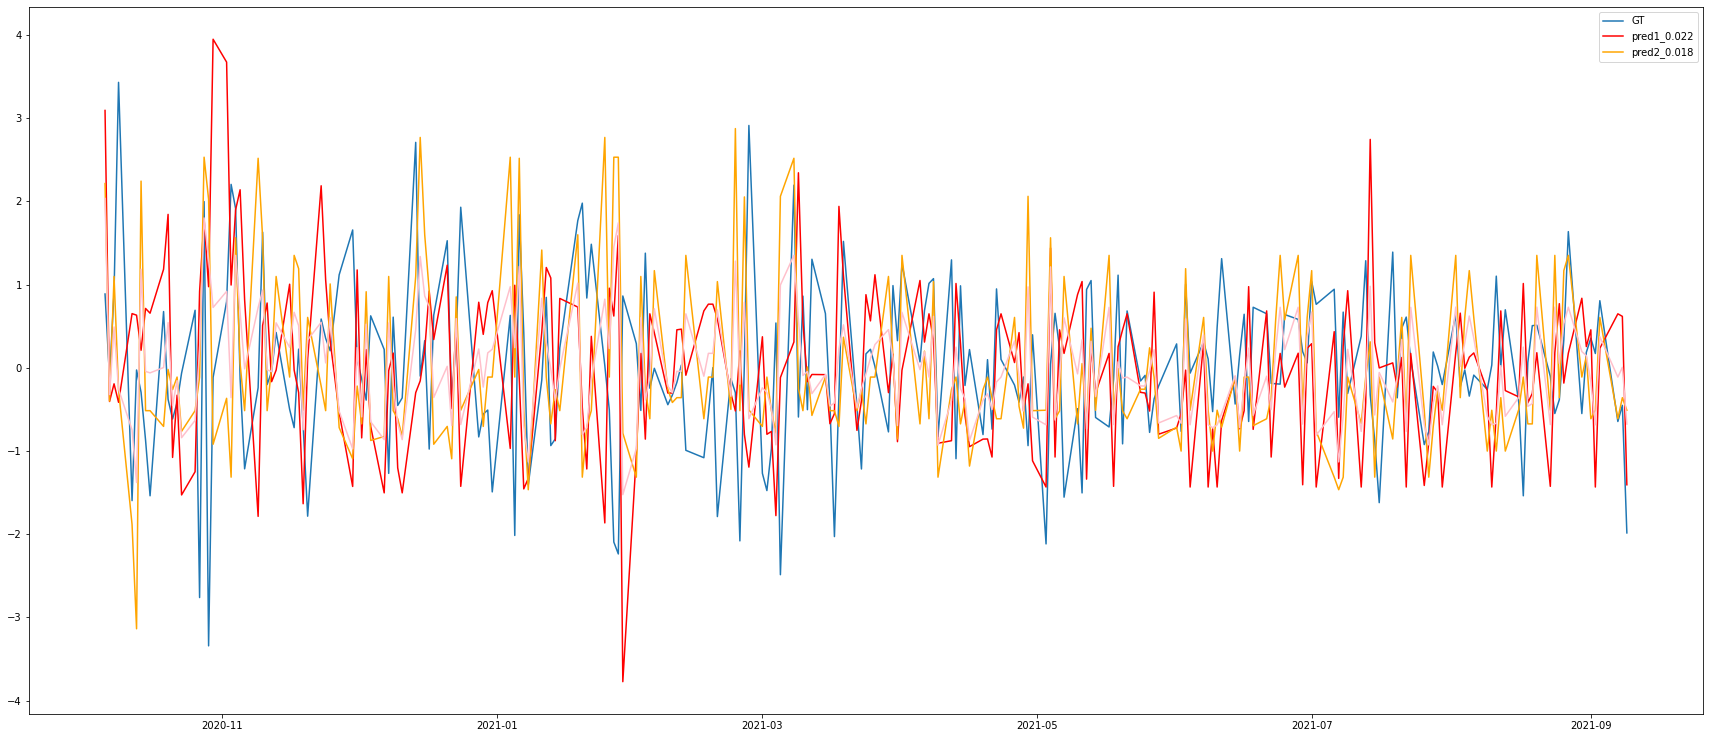

corr [[ 1.        -0.0324535]
 [-0.0324535  1.       ]]


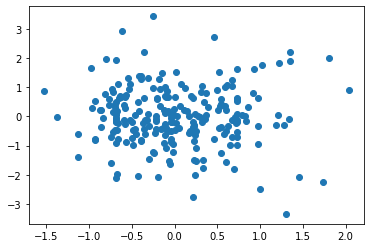

In [103]:
import lightgbm
from sklearn.preprocessing import StandardScaler
def rmse(y_test, y_pred): 
    return np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))

X_train, y_train, X_test, y_test, X_train_v, y_train_v, X_valid, y_valid = load_for_lgb()

best_params1 = {'lambda_l1': 1.701660243876869e-08, 
                'lambda_l2': 2.3791748634060543e-08, 
                'num_leaves': 127, 
                'feature_fraction': 0.62614724288909, 
                'bagging_fraction': 0.5294844114100681, 
                'bagging_freq': 1, 
                'min_child_samples': 6}

best_params2 = {'lambda_l1': 9.718969989268093e-05,
                'lambda_l2': 8.21231737250476e-06,
                'num_leaves': 122,
                'feature_fraction': 0.5524298734838154,
                'bagging_fraction': 0.7263476152701518,
                'bagging_freq': 4,
                'min_child_samples': 69}

best_params3 = {'lambda_l1': 9.85450233215797e-07,
                'lambda_l2': 0.019120874953742425,
                'num_leaves': 150,
                'feature_fraction': 0.5604835078684614,
                'bagging_fraction': 0.6580327606893868,
                'bagging_freq': 1,
                'min_child_samples': 26}

best_model1 = lightgbm.LGBMRegressor(**best_params1)
best_model2 = lightgbm.LGBMRegressor(**best_params2)

# lgb_train = lgb.Dataset(X_train, label=y_train)

best_model1.fit(X_train, y_train)
best_model2.fit(X_train, y_train)

pred1 = best_model1.predict(X_test)
pred2 = best_model2.predict(X_test)
train_pred2 = best_model2.predict(X_train)

score1 = rmse(pred1, y_test)
score2 = rmse(pred2, y_test)
train_score2 = rmse(train_pred2, y_train)

y_test_idx = y_test.index

print(f"score1, score2, train_score2 = {score1}, {score2},{train_score2}")
scaler = StandardScaler()
preds = [pred1, pred2, train_pred2]
pred1, pred2, train_pred2 = map(lambda element:np.array(element).reshape(-1,1), preds)

y_test,y_train, pred1, pred2, train_pred2 = list(map(scaler.fit_transform, [y_test.to_numpy(),y_train.to_numpy(), pred1, pred2, train_pred2]))
preds_av = pred2*0.5 + pred1*0.3
plt.figure(figsize=(30, 13))
# plt.plot(y_train)
# plt.plot(train_pred2)


y_test_idx, y_test, pred1, pred2, preds_av = tuple(map(lambda arr: arr[:], [y_test_idx, y_test, pred1, pred2, preds_av]))
plt.plot(y_test_idx,y_test)
plt.plot(y_test_idx,pred1, "red")
plt.plot(y_test_idx,pred2, "orange")
plt.plot(y_test_idx,preds_av,"pink")
# plt.xticks(y_test_idx[:100])
plt.legend(["GT",f"pred1_{round(score1,3)}", f"pred2_{round(score2, 3)}"])
plt.savefig("lightGBM_preds.png", facecolor="white",transparent=False)
plt.show()
plt.plot(preds_av, y_test, "o")
print("corr", np.corrcoef(preds_av.T, y_test.T))


In [104]:
pd.DataFrame(y_train).describe()

0
count  2109.000000
mean      0.000000
std       1.000237
min      -7.845416
25%      -0.432296
50%      -0.001375
75%       0.512198
max       6.354484

array([ 1., -1.,  1., ..., -1.,  1., -1.])

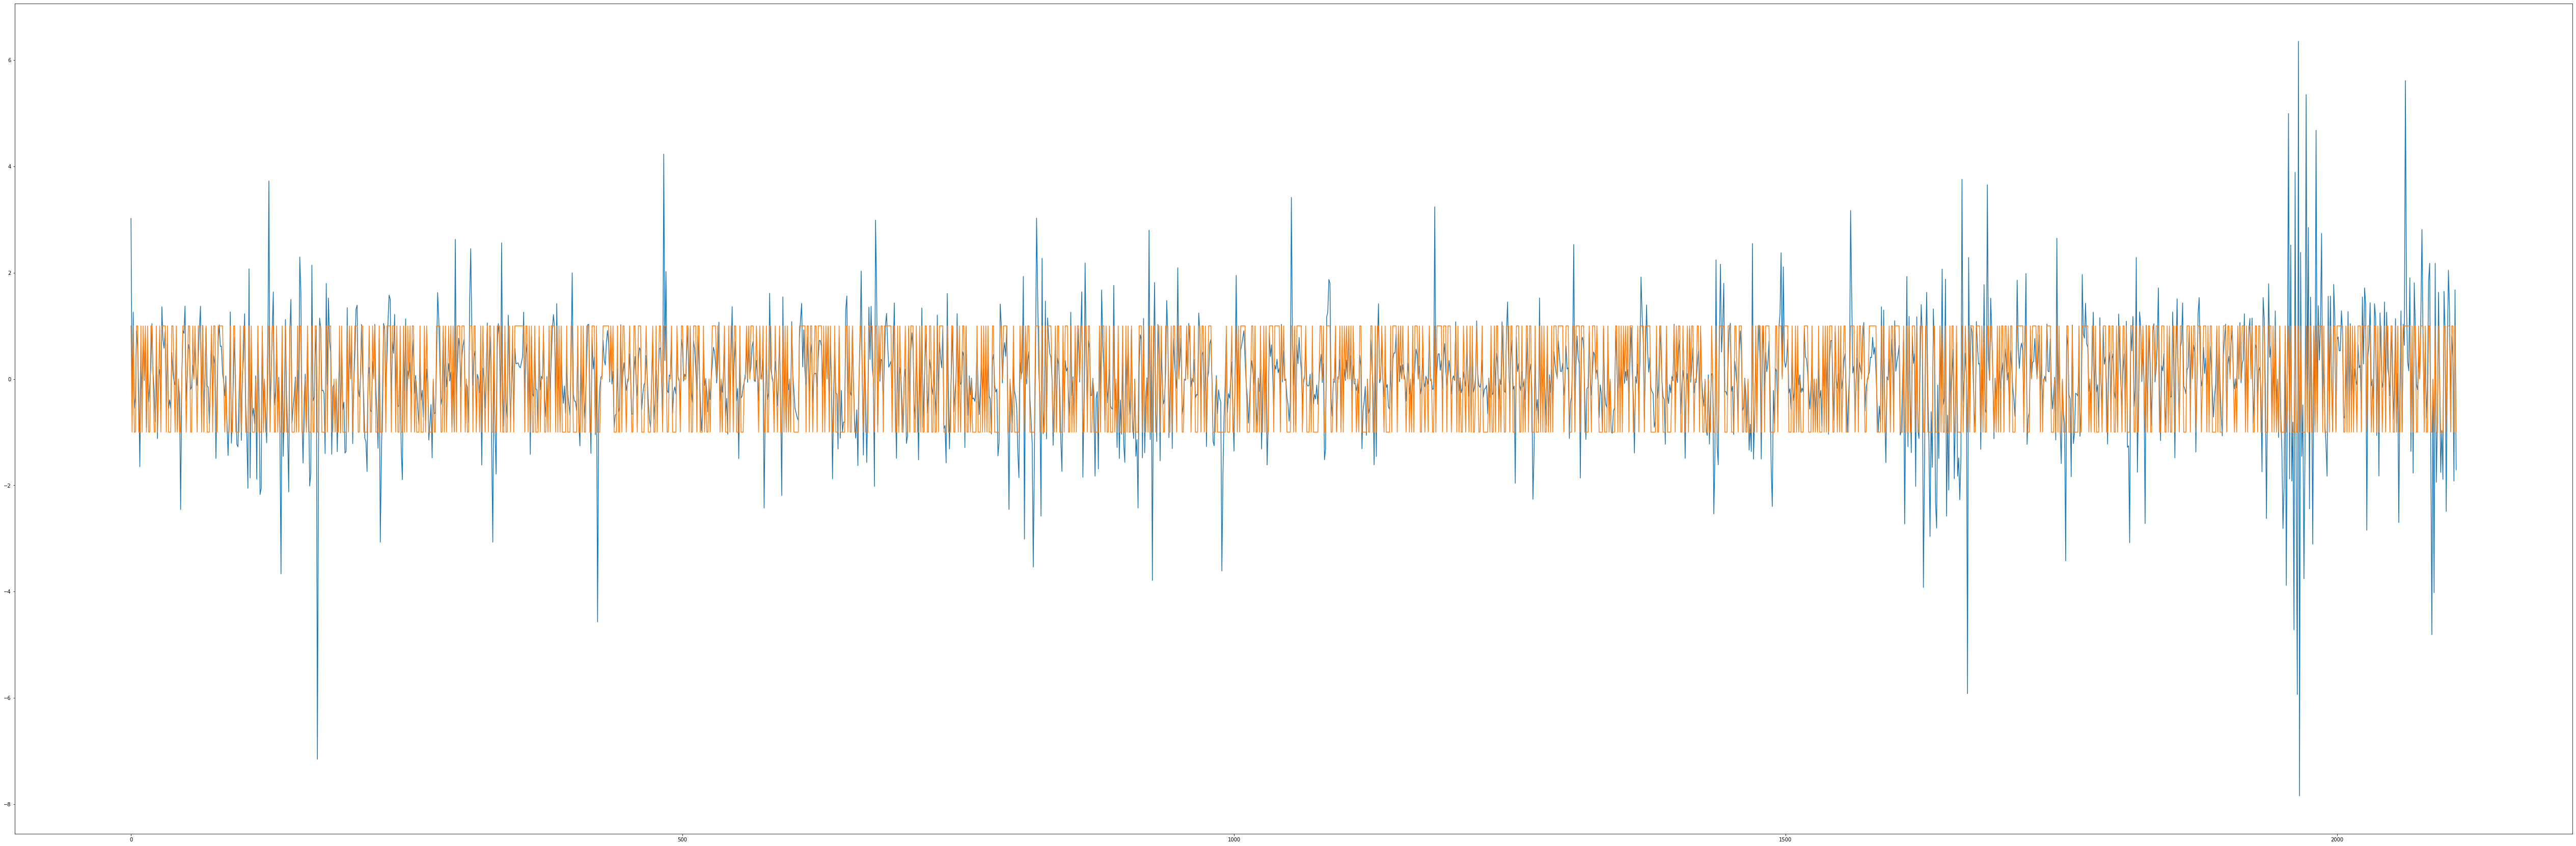

In [119]:
def to_three(y):
    if -0.1<y<0.1:
        y = 0.0
    elif y>=0.1:
        y = 1.0
    else:
        y = -1.0
    return y
    
def to_threes(arr):
    return np.array(list(map(lambda y: to_three(y), arr)))


y_train_three = to_threes(y_train)
plt.figure(figsize=(90, 30))
plt.plot(y_train)
plt.plot(y_train_three)
# plt.savefig("three_plt.png")
y_train_three

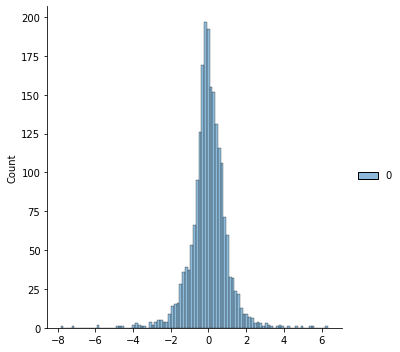

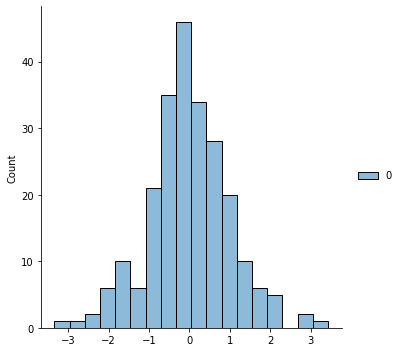

In [105]:
sns.displot(y_train)
sns.displot(y_test)

In [106]:
y_test_idx

DatetimeIndex(['2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09',
               '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15',
               '2020-10-16', '2020-10-19',
               ...
               '2021-08-26', '2021-08-27', '2021-08-30', '2021-08-31',
               '2021-09-01', '2021-09-02', '2021-09-03', '2021-09-07',
               '2021-09-08', '2021-09-09'],
              dtype='datetime64[ns]', name='Time', length=234, freq=None)